In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
from scipy.sparse import csr_matrix
from tqdm import tqdm
import capo.omni as omni
from copy import deepcopy
#import seaborn
%matplotlib notebook 

# Settings

In [105]:
pol = 'yy'
xants = [81]
dataFile = 'zen.2457678.39660.yy.HH.uvc'
firstCalFile = 'zen.2457678.39660.yy.HH.uvc.fc.npz'
calfile = 'hsa7458_v001'
minFreq, maxFreq = .108, .192

# Load Data and Apply FirstCal

In [2]:
meta,data,flags = miriad.read_files([dataFile],'cross',pol)
fcm,fcg,fcv,fcx = omni.from_npz(firstCalFile)
fcData = deepcopy(data)
for (ant1,ant2) in fcData.keys():
    if ant1 not in xants and ant2 not in xants:
        fcData[(ant1,ant2)][pol] /= (fcg[pol[0]][ant1] * np.conj(fcg[pol[0]][ant2]))    
freqs = meta['freqs']
nint, nchan = data.values()[0].values()[0].shape
antNames = np.sort(fcg.values()[0].keys())
aa = a.cal.get_aa(calfile, freqs)

# Omnical Data and Excise RFI

In [106]:
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
reds = info.get_reds()
antNames = [i for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants]
g0 = {pol[0]: {ant: np.ones((nint,nchan),dtype=complex) for ant in antNames}}
m1, g1, v1 = omni.redcal(fcData, info, gains=g0, removedegen=True, maxiter=50)
m2, g2, v2 = omni.redcal(fcData, info, vis=v1, gains=g1, uselogcal=False, removedegen=True, maxiter=50)


In [107]:
xrfiFlags = capo.xrfi.omni_chisq_to_flags(m2['chisq'])
flags = (np.sum(xrfiFlags,axis=0) > 0)
flags[freqs < minFreq] = True
flags[freqs > maxFreq] = True

# Add non-redundant baselines to omnical solutions

In [183]:
#print info.ublcount
#print info.ublindex
# print len(info.bl2d)
# print info.blperant
#print info.bltoubl
blPairs = [tuple(pair) for pair in info.bl2d]
#print len(fcData.keys())
#print len(blPairs)


# for ant1 in range(info.nAntenna):
#     for ant2 in range(info.nAntenna):
#         if not [ant1,ant2] in info.bl2d and not [ant2,ant1] in info.bl2d:
#             print [ant1,ant2]
            
#print info.nAntenna
#print np.array(info.get_reds())

redBLs = [bl for ublgroup in reds for bl in ublgroup]
for (ant1,ant2) in fcData.keys():
    if not ant1 in xants and not ant2 in xants:
        if not (ant1,ant2) in redBLs and not (ant2,ant1) in redBLs:
            print (ant1,ant2)

#print v2[pol].keys()
# print 
#print fcData.keys()


#print info.subsetant
#print info.ublcount
#print reds[1]
# print info.antloc[4] - info.antloc[17]
# print info.antloc[10] - info.antloc[1]
# print info.antloc[12] - info.antloc[15]
# print info.ubl[0]


(80, 97)
(72, 96)
(43, 88)


# Find overlaps in the uv-plane
First, find all possible orientations

Next, find orientations with more than one unique baseline associated

Next, determine regions of u with potential overlap


In [110]:
print len(info.ubl)

27


# Plotting

<IPython.core.display.Javascript object>


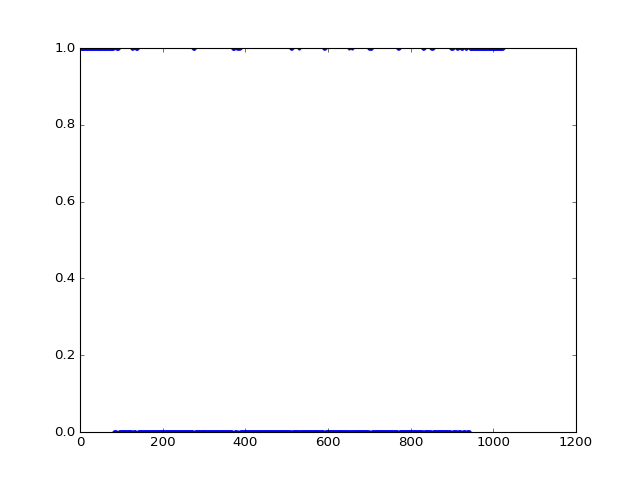

In [108]:

# meanVisAmplitude = np.mean(np.array([np.abs(vis) for vis in v2[pol].values()]),axis=(0,1))
# meanVisAmplitude *= (1-np.sum(xrfiFlags,axis=0) > 0)
# meanVisAmplitude[freqs<.108] = 0
# meanVisAmplitude[freqs>.192] = 0
# flags = meanVisAmplitude == 0

# #meanVisAmplitude *= (meanVisAmplitude < np.max(meanVisAmplitude)/1e2)
# #flags = meanVisAmplitude < 1e-10
# #meanVisAmplitude *= flags


plt.figure()
# plt.semilogy(meanVisAmplitude)
plt.plot(flags,'.')


In [74]:
plt.figure()
plt.imshow(, aspect='auto')

SyntaxError: invalid syntax (<ipython-input-74-c16ad0e0ce83>, line 2)

In [55]:
freqs

array([ 0.1       ,  0.10009766,  0.10019531, ...,  0.19970703,
        0.19980469,  0.19990234])